## Installation - Loading the Gymnasium custom environment: LifeSim

Since we're using a custom environment, we need to install its package into the pip environment, such that it will be usable from the gymnasium library. The following code is based on a Google Colab's run.

In [1]:
'''
# %%capture
#!rm -rf /content/gym_projects
!unzip - o / content/archive.zip
!pip uninstall - -no-input life-sim
!pip install - -no-input - e / content/gym_projects/
'''

'\n# %%capture\n#!rm -rf /content/gym_projects\n!unzip - o / content/archive.zip\n!pip uninstall - -no-input life-sim\n!pip install - -no-input - e / content/gym_projects/\n'

If the environment cannot be made with gymnasium.make(), it may be useful to restart the runtime.

In [2]:
'''
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()
'''


'\nimport os\n\ndef restart_runtime():\n  os.kill(os.getpid(), 9)\n\nrestart_runtime()\n'

## Creating the environment

In [54]:
import gymnasium as gym
import gymnasium.vector
import numpy as np
import tensorflow as tf
#from tensorflow import keras
#from keras import initializers
from collections import deque
import random
from life_sim.envs import LifeSim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from agent import DQN_Agent, Agent, PPO_Agent
import agent
#from tensorflow import GradientTape
import memory
import importlib
importlib.reload(gym)

<module 'gymnasium' from '/home/daniel/.local/lib/python3.10/site-packages/gymnasium/__init__.py'>

In [4]:

#tf.debugging.set_log_device_placement(True)
'''
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass
'''

2023-06-16 15:45:29.273108: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-06-16 15:45:29.273161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: besaro
2023-06-16 15:45:29.273168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: besaro
2023-06-16 15:45:29.273272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.41.3
2023-06-16 15:45:29.273292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.41.3
2023-06-16 15:45:29.273297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.41.3


Adding some useful settings and dictionaries to ease the code

In [55]:
# numpy settings for printing the states, if needed
np.set_printoptions(precision=4)

# some useful dictionaries used to let the code be more readable
# and less error-prone
num_actions = 3

actions = {
    "work": 0,
    "sport": 1,
    "sociality": 2
}

actions_array = {
    0: np.transpose([1, 0, 0]),
    1: np.transpose([0, 1, 0]),
    2: np.transpose([0, 0, 1]),
}

state_map = {
    "money": 0,
    "health": 1,
    "work development": 2,
    "social development": 3,
}

### Utils

Here we code some useful functions to visualize the results of the training and evaluate the model performance on the environment.

In [6]:
def plot_results(observations, rewards):
    # Plotting the first set of data
    performances = np.transpose(observations)
    plt.figure(1)
    plt.plot(performances[state_map['money']], label='Money')
    plt.plot(performances[state_map['health']], label='Health')
    plt.plot(performances[state_map['work development']],
             label='Work Development')
    plt.plot(performances[state_map['social development']],
             label='Social Development')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('State plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Rewards plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(3)
    plt.plot(np.cumsum(rewards), label='Cumulative Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Cumulative reward plot')
    plt.legend()

    # Displaying the plots
    plt.show()


In [7]:
def training_results(rewards, actions, normalize=False):
    # Normalize the data
    actions = np.transpose(actions)

    if normalize:
        f = np.max(rewards)
        rewards = [r/f for r in rewards]
        f = np.max([np.max(actions[i]) for i in range(len(actions))])
        actions = [[a/f for a in actions[i]] for i in range(len(actions))]

    # Plotting the first set of data
    plt.figure(1)
    plt.plot(actions[0], label='Work')
    plt.plot(actions[1], label='Sport')
    plt.plot(actions[2], label='Sociality')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(actions[0]), 1))
    plt.title('# of Actions, per training step')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Cumulative Reward')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(rewards), 1))
    plt.title('Cumulative Rewards plot, per training step')
    plt.legend()

    # Displaying the plots
    plt.show()


In [8]:
def plot_losses(actor_loss, critic_loss, logscale = False, reduce_n=None):

    if reduce_n is not None:
        actor_loss = np.array(actor_loss).reshape(-1, reduce_n).mean(axis=1)
        critic_loss = np.array(critic_loss).reshape(-1, reduce_n).mean(axis=1)

    plt.figure(1)
    plt.plot(actor_loss, label='Mean Actor Loss per Update')
    plt.xlabel('Updates')
    plt.xticks(np.arange(1,len(actor_loss),1))
    plt.ylabel('Mean loss')
    if logscale: plt.yscale('log')
    plt.title('Actor Loss Plot')
    plt.legend()

    plt.figure(2)
    plt.plot(critic_loss, label='Mean Critic Loss per Update')
    plt.xlabel('Updates')
    if logscale: plt.yscale('log')
    plt.xticks(np.arange(1,len(critic_loss),1))
    plt.ylabel('Mean loss')
    plt.title('Critic Loss Plot')
    plt.legend()

    # Displaying the plots
    plt.show()


### Training the Agent

In [9]:
def training_step(agent: Agent, batch_size):

    loss = agent.train(replay_buffer, batch_size)
    return loss


def add_cumulative_reward(cumulative_rewards, avg_sum_reward, sum_rewards, tau):

    avg_sum_reward = (avg_sum_reward*(tau - 1) + sum_rewards)/tau
    cumulative_rewards.append(avg_sum_reward)


def add_sum_action(sum_actions, avg_sum_actions, actions, tau):

    avg_sum_actions = (np.dot(avg_sum_actions, (tau - 1)) + actions)/tau
    sum_actions.append(avg_sum_actions)


def calc_epsilon(episode, n_episodes, decay):
    return max(1 - episode/(n_episodes*decay), 0.05)


In [10]:
def play_one_step(vec_env, v_actions, epsilon):

    next_states, rewards, terminateds, truncateds, infos = vec_env.step(v_actions)
    return next_states, rewards, terminateds, truncateds, infos, v_actions


In [11]:
def play_episodes(n_episodes, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    for episode in tqdm(np.arange(1, n_episodes, 1), desc="Episodes", position=0):

        sum_rewards = 0
        actions = np.transpose([0, 0, 0])

        v_obs, v_info = vec_env.reset()

        for step in np.arange(1, max_steps, 1):

            epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

            actions = [dqn_agent.predict(o, 0.5) for o in obs]

            v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(
                vec_env, actions, epsilon)
            [replay_buffer.append((v_obs[i], v_action[i], v_reward[i],
                                  v_new_obs[i], v_terminated[i])) for i in range(len(obs))]

            sum_rewards = sum_rewards + np.sum(v_reward)
            actions = actions + actions_array[v_info['last_action']]

            []
            # env.render()
            # if terminated or truncated:
            #    break

        if episode % tau == 0:

            add_cumulative_reward(cumulative_rewards,
                                  avg_sum_reward, sum_rewards, tau)
            add_sum_action(sum_actions, avg_sum_actions, actions, tau)
        else:

            avg_sum_reward = (avg_sum_reward*(episode %
                              tau - 1) + sum_rewards)/(episode % tau)
            avg_sum_actions = (
                np.dot(avg_sum_actions, (episode % tau - 1)) + actions)/(episode % tau)

            if episode > 10 and episode % tau == 0:
                training_step(dqn_agent, batch_size)

    return cumulative_rewards, sum_actions


In [12]:
def play_steps(vec_env, max_steps, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    steps = 0

    v_obs, v_info = vec_env.reset(seed=seeds)

    sum_rewards = 0
    actions = np.transpose([0, 0, 0])


    for steps in tqdm(np.arange(1, max_steps, 1), desc="Steps", position=0):

        epsilon = calc_epsilon(steps, max_steps, decay=0.8)
        v_actions = np.array([dqn_agent.predict(o, 0) for o in v_obs])
        #v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)
        v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)

        # save in buffer for the resetted envs
        # different code because of the vec_env.step() behaviour in case of truncated or terminated episode
        resetted_envs = [i for i in range(len(v_truncated)) if v_truncated[i] or v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_info['final_observation'][i], v_terminated[i]) for i in resetted_envs])

        # save in buffer
        not_resetted_envs = [i for i in range(len(v_truncated)) if not v_truncated[i] and not v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_new_obs[i], v_terminated[i]) for i in not_resetted_envs])

        #sum_rewards = sum_rewards + np.sum(v_reward)
        #actions = actions + \
        #    actions_array[np.sum(v_info['last_action'], axis=1)]

        if steps % tau == 0:
            training_step(dqn_agent, batch_size)

    
    return cumulative_rewards, sum_actions


In [13]:
'''
from tensorflow.compat import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
'''

'\nfrom tensorflow.compat import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\n\nconfig = ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.2\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)\n'

In [56]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300
num_envs = 32
seeds = [int(x) for x in np.random.randint(1, 100000 + 1, size=num_envs)]

# create the vectorized environment
vec_env = gymnasium.vector.make(
    'life_sim/LifeSim-v0', num_envs=num_envs, asynchronous=True)
#vec_env = gymnasium.vector.make(
#    'CartPole-v0', num_envs=num_envs, asynchronous=True)


In [57]:
input_shape = [vec_env.single_observation_space.shape[0]]
#input_shape = [vec_env.single_observation_space.shape[0]]
n_outputs = vec_env.single_action_space.n

In [16]:
num_steps = 50000
gamma = 0.99
lmbda = 0.95
epsilon = 0.2
c2 = 0.1
batch_timesteps = 128
minibatch_size = 32
epochs = batch_timesteps // minibatch_size

lr = 1e-4

In [17]:
'''
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.con
#import tensorflow as tf
#from tensorflow import keras
#from keras import initializersfig.experimental.VirtualDeviceConfiguration(memory_limit=1600)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
'''

'\ngpus = tf.config.experimental.list_physical_devices(\'GPU\')\nif gpus:\n  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU\n  try:\n    tf.config.experimental.set_virtual_device_configuration(\n        gpus[0],\n        [tf.con\n#import tensorflow as tf\n#from tensorflow import keras\n#from keras import initializersfig.experimental.VirtualDeviceConfiguration(memory_limit=1600)])\n    logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n  except RuntimeError as e:\n    # Virtual devices must be set before GPUs have been initialized\n    print(e)\n'

In [18]:
#ppo_critic_optimizer = keras.optimizers.AdamW(learning_rate=lr)
#ppo_actor_optimizer = keras.optimizers.AdamW(learning_rate=lr)

In [19]:
m = memory.Memory(num_envs = num_envs, obs_shape = vec_env.single_observation_space.shape, timesteps = batch_timesteps)

In [20]:
import agent
importlib.reload(agent)
ppo_agent = agent.PPO_Agent(input_shape, n_outputs, gamma, lmbda, epsilon, c2, lr)

In [21]:
#from agent import play_n_timesteps
mean_losses_actor, mean_losses_critic = ppo_agent.play_n_timesteps(vec_env, m, num_steps, batch_timesteps, minibatch_size, epochs)

  0%|          | 0/390 [00:00<?, ?it/s]

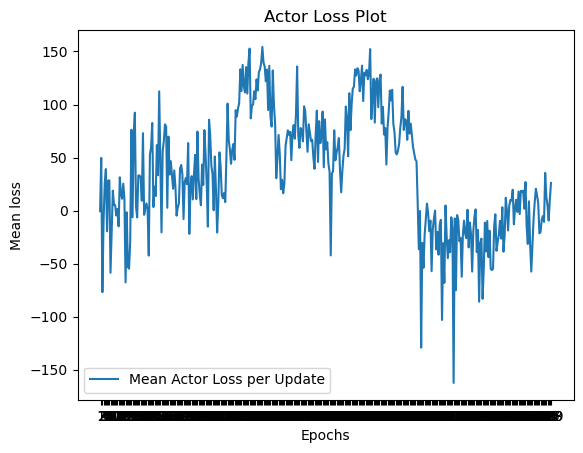

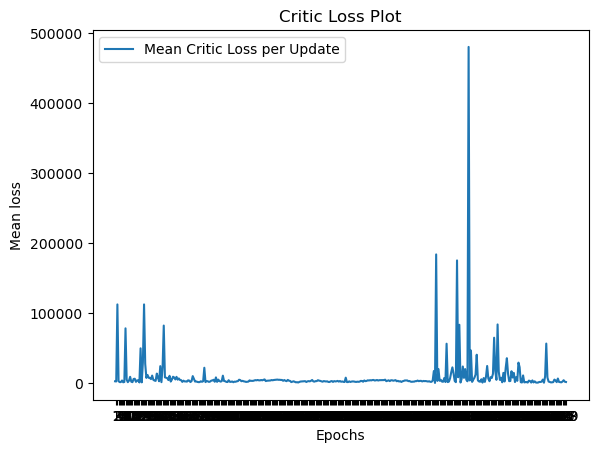

In [30]:
plot_losses(mean_losses_actor, mean_losses_critic, logscale = False, reduce_n=None)

In [45]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300

# create the vectorized environment
env = gymnasium.make('life_sim/LifeSim-v0', render_mode='text')

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 200

for episode in tqdm(np.arange(1, n_episodes+1, 1), desc="Episodes", position=0):

    print(f"Episode {episode}")
    sum_rewards = 0
    actions = np.transpose([0, 0, 0])

    obs, info = env.reset()

    #for step in np.arange(1, max_steps, 1):
    while True:    
        epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

        action, _ , _= ppo_agent.get_action(obs[np.newaxis])

        action = tf.squeeze(action).numpy()
        new_obs, reward, terminated, truncated, info = env.step(action)

        actions = actions + actions_array[action]

        sum_rewards += reward
#        actions = actions + actions_array[v_info['last_action']]

        env.render()
        if terminated or truncated:
           break

    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)

Episodes:   0%|          | 0/199 [00:00<?, ?it/s]

Episode 1
State -> [3.9796 2.8122 2.2776 1.5803]  |  Reward: 0  |  Last Action: work  |
State -> [3.4796 2.5122 2.2076 1.8803]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.9796 2.2122 2.1376 2.1803]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.4796 2.9122 2.0676 2.0803]  |  Reward: 0  |  Last Action: sport  |
State -> [1.9796 2.6122 1.9976 2.3803]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.4796 2.3122 2.2276 2.2803]  |  Reward: 0  |  Last Action: work  |
State -> [1.9796 2.0122 2.1576 2.5803]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.4796 1.7122 2.3876 2.4803]  |  Reward: 0  |  Last Action: work  |
State -> [1.9796 1.4122 2.3176 2.7803]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.4796 1.1122 2.5476 2.6803]  |  Reward: 0  |  Last Action: work  |
State -> [2.9796 0.8122 2.7776 2.5803]  |  Reward: 0  |  Last Action: work  |
State -> [3.4796 0.5122 3.0076 2.4803]  |  Reward: 0  |  Last Action: work  |
State -> [2.9796 1.2122 2.93

/home/daniel/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


State -> [3.102  2.7918 2.0191 1.5667]  |  Reward: 0  |  Last Action: work  |
State -> [3.602  2.4918 2.2491 1.4667]  |  Reward: 0  |  Last Action: work  |
State -> [3.102  2.1918 2.1791 1.7667]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.602  1.8918 2.1091 2.0667]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.102  1.5918 2.0391 2.3667]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.602  1.2918 2.2691 2.2667]  |  Reward: 0  |  Last Action: work  |
State -> [3.102  0.9918 2.4991 2.1667]  |  Reward: 0  |  Last Action: work  |
State -> [2.602  0.6918 2.4291 2.4667]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.102  0.3918 2.3591 2.7667]  |  Reward: 0  |  Last Action: sociality  |
State -> [1.602  1.0918 2.2891 2.6667]  |  Reward: 0  |  Last Action: sport  |
State -> [1.102  0.7918 2.2191 2.9667]  |  Reward: 0  |  Last Action: sociality  |
State -> [1.602  0.4918 2.4491 2.8667]  |  Reward: 0  |  Last Action: work  |
State -> [1.102  0.1918 2.3791 3.

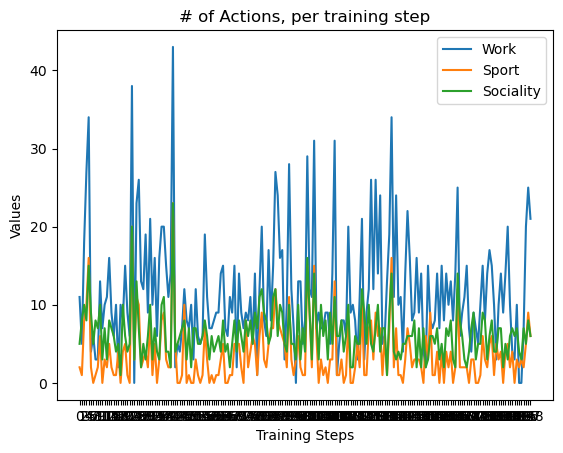

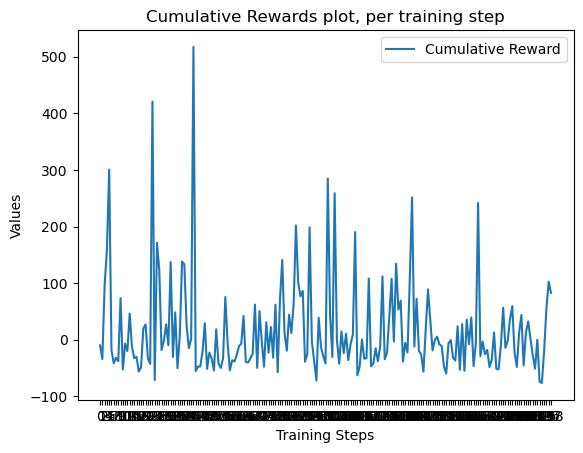

In [46]:
training_results(cumulative_rewards, sum_actions)

Let's print the mean of the cumulative rewards obtained in the previous 50 evaluated episodes:

In [47]:
print(np.mean(cumulative_rewards))

15.412909837224376


In [ ]:
tau = 100
max_steps = 1585

cumulative_rewards, sum_actions = play_steps(vec_env, max_steps, tau)


Steps:   0%|          | 0/1584 [00:00<?, ?it/s]

AttributeError: module 'tensorflow' has no attribute 'arg'

In [ ]:
len(replay_buffer)

1584

In [ ]:
training_results(cumulative_rewards, sum_actions, normalize=True)


ValueError: zero-size array to reduction operation maximum which has no identity

In [51]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300

# create the vectorized environment
env = gymnasium.make('life_sim/LifeSim-v0', render_mode='text')

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 200

for episode in tqdm(np.arange(1, n_episodes+1, 1), desc="Episodes", position=0):

    print(f"Episode {episode}")
    sum_rewards = 0
    actions = np.transpose([0, 0, 0])

    obs, info = env.reset()

    #for step in np.arange(1, max_steps, 1):
    while True:    
        epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

        action = np.random.randint(3)

        new_obs, reward, terminated, truncated, info = env.step(action)

        actions = actions + actions_array[action]

        sum_rewards += reward
#        actions = actions + actions_array[v_info['last_action']]

        env.render()
        if terminated or truncated:
           break

    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)

Episodes:   0%|          | 0/200 [00:00<?, ?it/s]

Episode 1
State -> [3.6122 2.4653 2.4273 1.6483]  |  Reward: 0  |  Last Action: work  |
State -> [3.1122 2.1653 2.3573 1.9483]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.6122 1.8653 2.2873 2.2483]  |  Reward: 0  |  Last Action: sociality  |
State -> [3.1122 1.5653 2.5173 2.1483]  |  Reward: 0  |  Last Action: work  |
State -> [2.6122 2.2653 2.4473 2.0483]  |  Reward: 0  |  Last Action: sport  |
State -> [2.1122 1.9653 2.3773 2.3483]  |  Reward: 0  |  Last Action: sociality  |
State -> [1.6122 1.6653 2.3073 2.6483]  |  Reward: 0  |  Last Action: sociality  |
State -> [1.1122 2.3653 2.2373 2.5483]  |  Reward: 0  |  Last Action: sport  |
State -> [1.6122 2.0653 2.4673 2.4483]  |  Reward: 0  |  Last Action: work  |
State -> [2.1122 1.7653 2.6973 2.3483]  |  Reward: 0  |  Last Action: work  |
State -> [1.6122 1.4653 2.6273 2.6483]  |  Reward: 0  |  Last Action: sociality  |
State -> [1.1122 2.1653 2.5573 2.5483]  |  Reward: 0  |  Last Action: sport  |
State -> [1.6122 1.8653 2.

/home/daniel/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


State -> [2.     1.7837 2.7329 2.8293]  |  Reward: 0  |  Last Action: work  |
State -> [2.5    1.4837 2.9629 2.7293]  |  Reward: 0  |  Last Action: work  |
State -> [3.     1.1837 3.1929 2.6293]  |  Reward: 0  |  Last Action: work  |
State -> [2.5    1.8837 3.1229 2.5293]  |  Reward: 0  |  Last Action: sport  |
State -> [3.     1.5837 3.3529 2.4293]  |  Reward: 0  |  Last Action: work  |
State -> [3.5    1.2837 3.5829 2.3293]  |  Reward: 0  |  Last Action: work  |
State -> [3.     1.9837 3.5129 2.2293]  |  Reward: 0  |  Last Action: sport  |
State -> [3.5    1.6837 3.7429 2.1293]  |  Reward: 0  |  Last Action: work  |
State -> [3.     2.3837 3.6729 2.0293]  |  Reward: 0  |  Last Action: sport  |
State -> [3.5    2.0837 3.9029 1.9293]  |  Reward: 0  |  Last Action: work  |
State -> [3.     1.7837 3.8329 2.2293]  |  Reward: 0  |  Last Action: sociality  |
State -> [2.5    2.4837 3.7629 2.1293]  |  Reward: 0  |  Last Action: sport  |
State -> [2.     3.1837 3.6929 2.0293]  |  Reward: 0  |

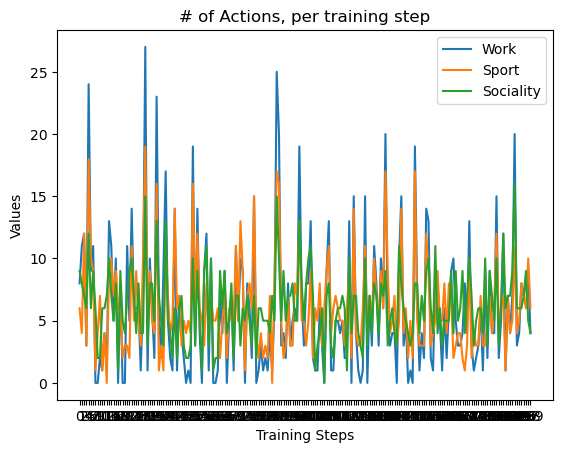

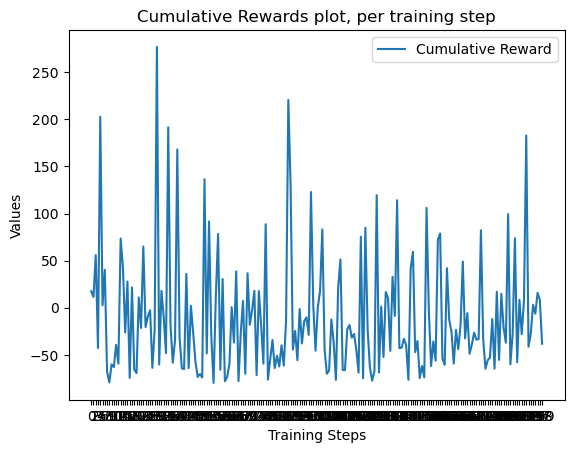

In [52]:
training_results(cumulative_rewards, sum_actions)

Let's print the mean of the cumulative rewards obtained in the previous 50 evaluated episodes, taking random actions:

In [53]:
print(np.mean(cumulative_rewards))

-11.082504367828369


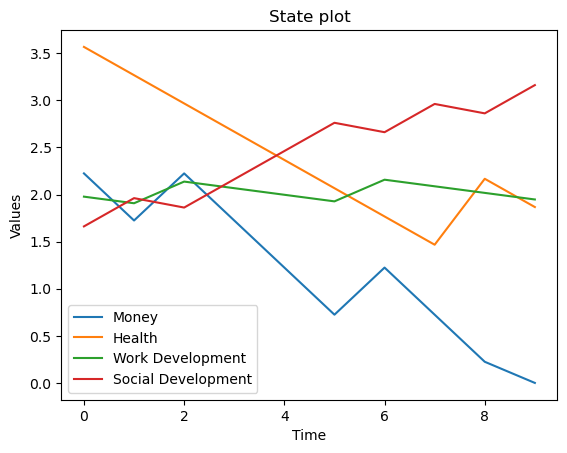

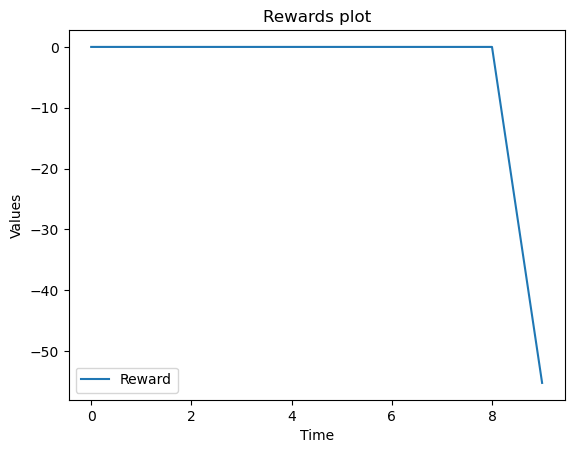

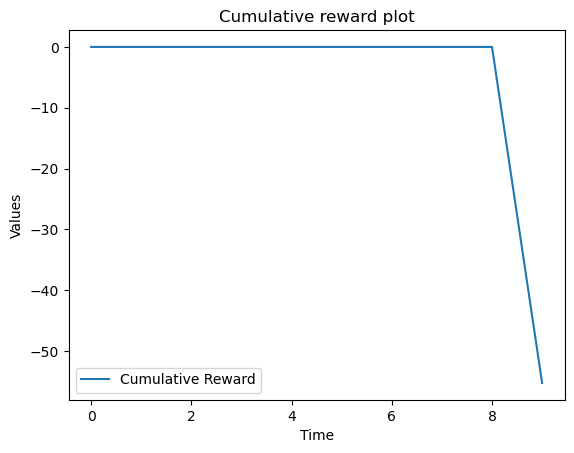

In [35]:
observations = []
rewards = []

obs, info = env.reset()

done = False
terminated = False
while not done and not terminated:
    obs, reward, terminated, truncated, info = env.step(np.random.randint(3))
    # print(np.array2string(obs))
    observations.append(obs)
    # print(np.array2string(reward))
    rewards.append(reward)
    if terminated or truncated:
        break

plot_results(observations, rewards)


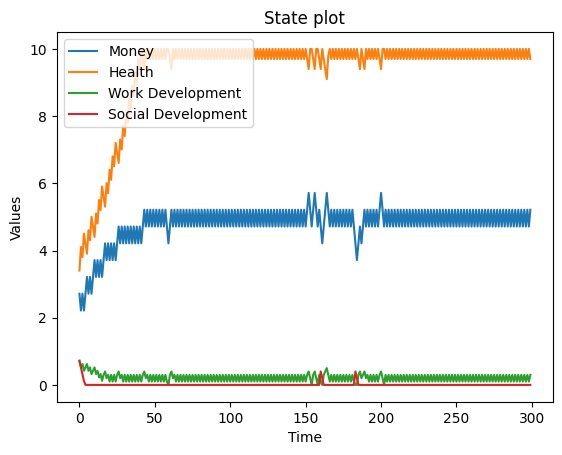

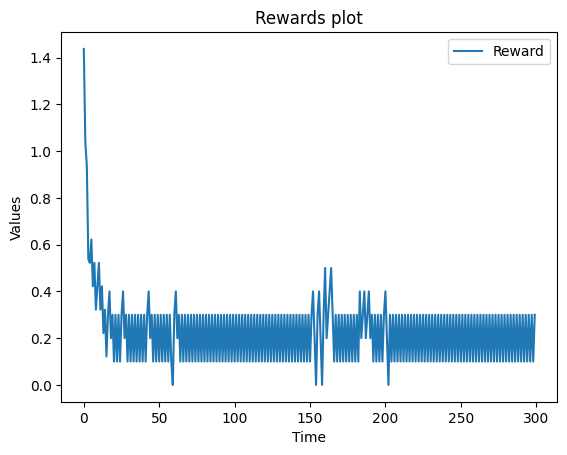

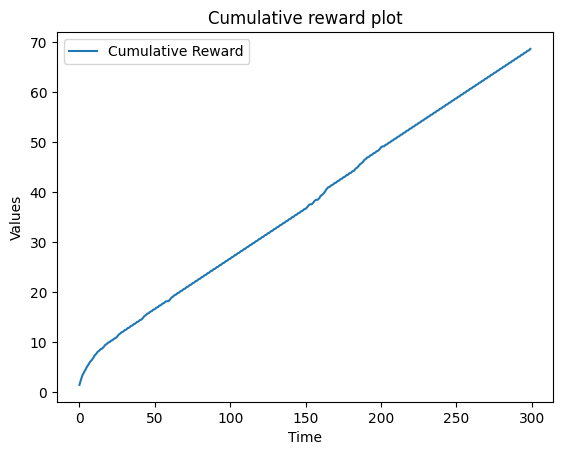

In [ ]:
observations = []
rewards = []

for episode in range(1):

    obs, info = env.reset()
    for step in range(1000):
        epsilon = 0.05
        obs, reward, terminated, truncated, info, action = dqn_agent.play_one_step(
            env, obs, epsilon)
        observations.append(obs)
        rewards.append(reward)
        # env.render()
        if terminated or truncated:
            break

plot_results(observations, rewards)
